In [1]:
# imports
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

### Regression line vs other lines

In [2]:
def standard_units(arr):
    """ Converts an array to standard units """
    return (arr - np.average(arr))/np.std(arr)

def correlation(t, x, y):
    """ Computes correlation: t is a table, and x and y are column names """
    x_standard = standard_units(t.column(x))
    y_standard = standard_units(t.column(y))
    return np.average(x_standard * y_standard)

def slope(t, x, y):
    """ Computes the slope of the regression line, like correlation above """
    r = correlation(t, x, y)
    y_sd = np.std(t.column(y))
    x_sd = np.std(t.column(x))
    return r * y_sd / x_sd

def intercept(t, x, y):
    """ Computes the intercept of the regression line, like slope above """
    x_mean = np.mean(t.column(x))
    y_mean = np.mean(t.column(y))
    return y_mean - slope(t, x, y)*x_mean

def fitted_values(t, x, y):
    """Return an array of the regression estimates (predictions) at all the x values"""
    a = slope(t, x, y)
    b = intercept(t, x, y)
    return a*t.column(x) + b

def demographics_errors(slope, intercept):
    # Use four convenient points from the original data
    sample = [[14.7, 33995], [19.1, 61454], [50.7, 71183], [59.5, 105918]]
    demographics.scatter('College%', 'Median Income', alpha=0.5)
    xlims = make_array(5, 75)
    # Plot a line with the slope and intercept you specified:
    plots.plot(xlims, slope * xlims + intercept, lw=4)
    # Plot red lines from each of the four points to the line
    for x, y in sample:
        plots.plot([x, x], [y, slope * x + intercept], color='r', lw=4)
        
def show_demographics_rmse(slope, intercept):
    demographics_errors(slope, intercept)
    x = demographics.column('College%')
    y = demographics.column('Median Income')
    prediction = slope * x + intercept
    mse = np.mean((y - prediction) ** 2)
    print("Root mean squared error:", round(mse ** 0.5, 2))

### Error in Estimation

In [3]:
demographics = Table.read_table('district_demographics2016.csv')
demographics.show(5)

State,District,Median Income,Percent voting for Clinton,College%
Alabama,"Congressional District 1 (115th Congress), Alabama",47083,34.1,24
Alabama,"Congressional District 2 (115th Congress), Alabama",42035,33,21.8
Alabama,"Congressional District 3 (115th Congress), Alabama",46544,32.3,22.8
Alabama,"Congressional District 4 (115th Congress), Alabama",41110,17.4,17
Alabama,"Congressional District 5 (115th Congress), Alabama",51690,31.3,30.3


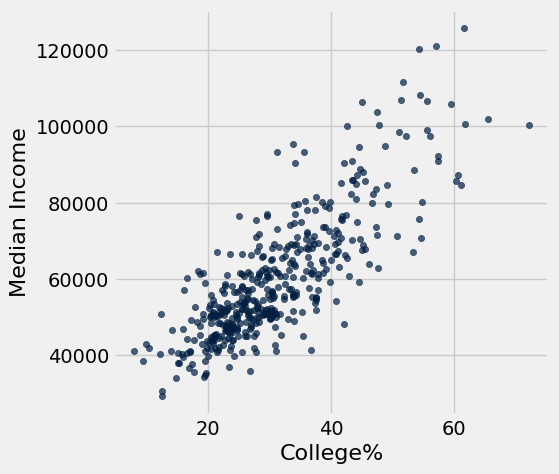

In [4]:
demographics = demographics.drop(
    'State', 'District', 'Percent voting for Clinton')
demographics.scatter('College%', 'Median Income')

In [5]:
regression_slope = slope(demographics, 'College%', 'Median Income')
regression_intercept = intercept(demographics, 'College%', 'Median Income')
regression_slope, regression_intercept

(1270.70168946388, 20802.577766677925)

In [6]:
predicted = fitted_values(demographics, 'College%', 'Median Income')

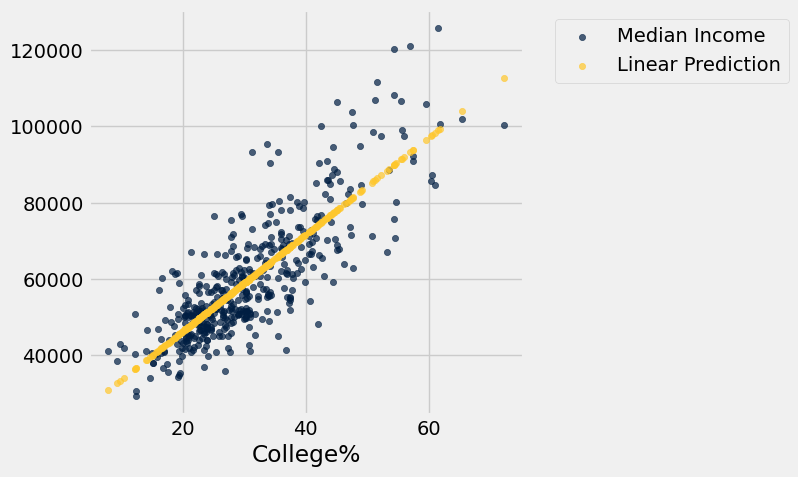

In [7]:
demographics = demographics.with_column(
    'Linear Prediction', predicted)
demographics.scatter('College%')

In [8]:
actual = demographics.column('Median Income')
errors = actual - predicted

In [9]:
demographics.with_column('Error', errors)

Median Income,College%,Linear Prediction,Error
47083,24,51299.4,-4216.42
42035,21.8,48503.9,-6468.87
46544,22.8,49774.6,-3230.58
41110,17,42404.5,-1294.51
51690,30.3,59304.8,-7614.84
61413,36.7,67437.3,-6024.33
34664,19.4,45454.2,-10790.2
76440,29.6,58415.3,18024.7
50537,24.5,51934.8,-1397.77
49072,34,64006.4,-14934.4


In [10]:
np.mean(errors**2) **0.5

9398.5155885712811

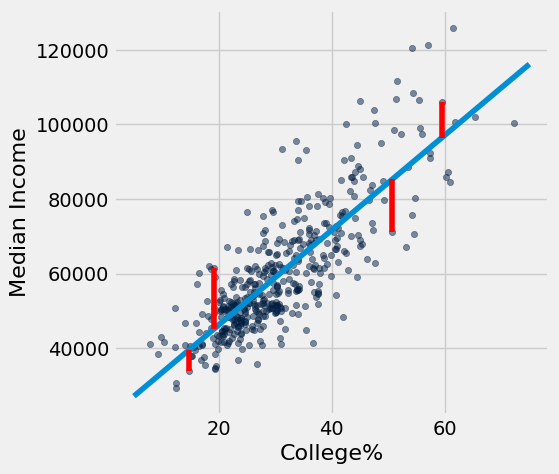

In [11]:
demographics_errors(regression_slope,regression_intercept)

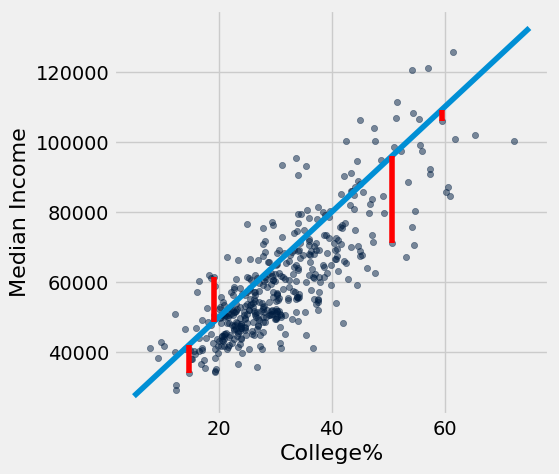

In [12]:
# takes any slope, any intercept
demographics_errors(1500,20000)

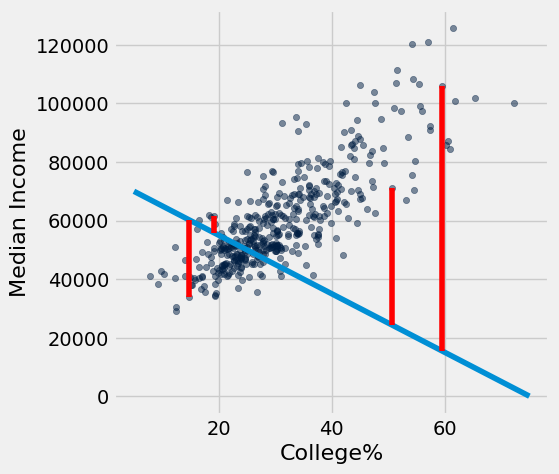

In [13]:
demographics_errors(-1000,75000)

### Root Mean Square Error ###

Root mean squared error: 30247.88


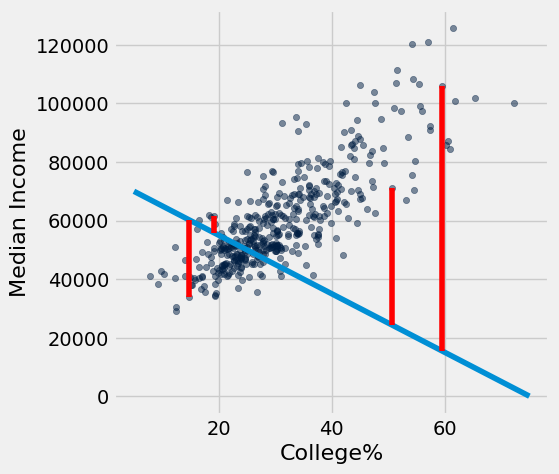

In [14]:
show_demographics_rmse(-1000, 75000)

Root mean squared error: 9402.1


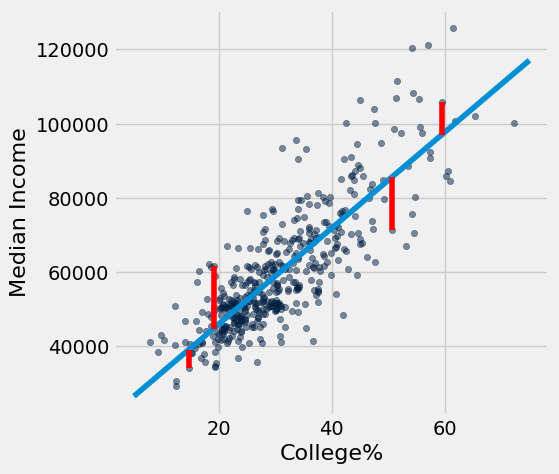

In [18]:
show_demographics_rmse(1294.4, 20000)

Root mean squared error: 9398.52


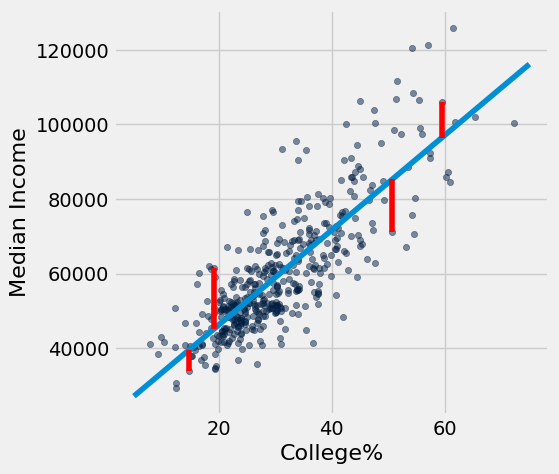

In [19]:
show_demographics_rmse(regression_slope, regression_intercept)

### Numerical Optimization ###

Consider $y =(x-2)^2 +3$

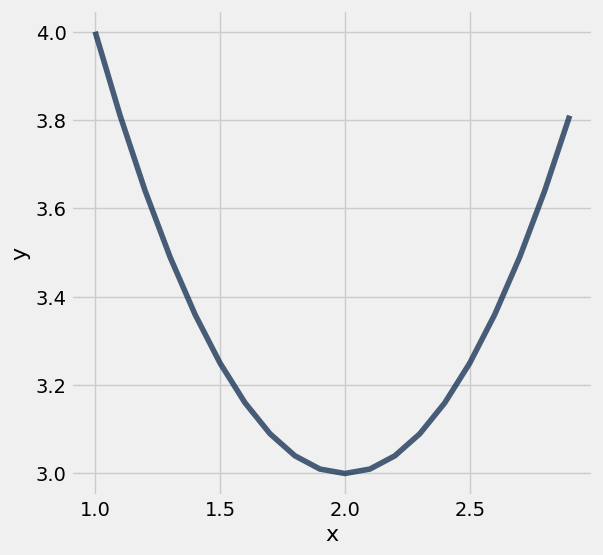

In [20]:
x = np.arange(1, 3, 0.1)
y = (x-2)**2 + 3
Table().with_columns('x', x, 'y', y).plot('x')

In [21]:
def f(x):
    return (x-2)**2 + 3

In [22]:
minimize(f)

1.9999999946252267

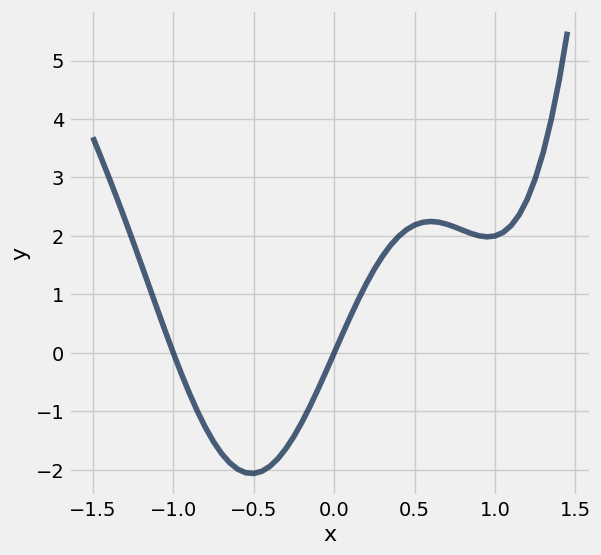

In [23]:
x = np.arange(-1.5, 1.5, 0.05)
y2 = 2 * np.sin(x*np.pi) + x ** 3 + x ** 4 
Table().with_columns('x', x, 'y', y2).plot('x')

In [24]:
def complicated_function(x):
    return 2 * np.sin(x*np.pi) + x ** 3 + x ** 4 

In [25]:
minimize(complicated_function)

-0.5126437620940081

### Minimizing RMSE ###

In [26]:
def demographics_rmse(any_slope, any_intercept):
    x = demographics.column('College%')
    y = demographics.column('Median Income')
    estimate = any_slope*x + any_intercept
    return np.mean((y - estimate)**2)**0.5

In [27]:
demographics_rmse(1500, 20000)

11559.086490075999

In [28]:
demographics_rmse(-1000, 75000)

30247.883767944502

In [29]:
minimize(demographics_rmse)

array([  1270.70168805,  20802.57933807])

In [30]:
make_array(regression_slope, regression_intercept)

array([  1270.70168946,  20802.57776668])

### Nonlinear Regression ###

In [31]:
shotput = Table.read_table('shotput.csv')
shotput

Weight Lifted,Shot Put Distance
37.5,6.4
51.5,10.2
61.3,12.4
61.3,13
63.6,13.2
66.1,13
70,12.7
92.7,13.9
90.5,15.5
90.5,15.8


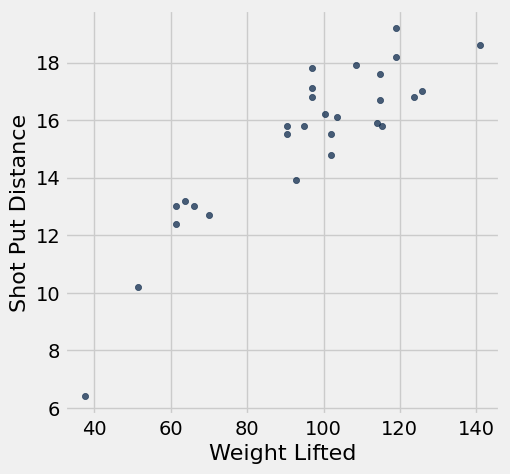

In [32]:
shotput.scatter('Weight Lifted')

In [33]:
def shotput_linear_rmse(any_slope, any_intercept):
    x = shotput.column('Weight Lifted')
    y = shotput.column('Shot Put Distance')
    estimate = any_slope*x + any_intercept
    return np.mean((y - estimate) ** 2) ** 0.5

In [34]:
best_line = minimize(shotput_linear_rmse)
best_line

array([ 0.09834382,  5.95962883])

In [35]:
weights = shotput.column(0)

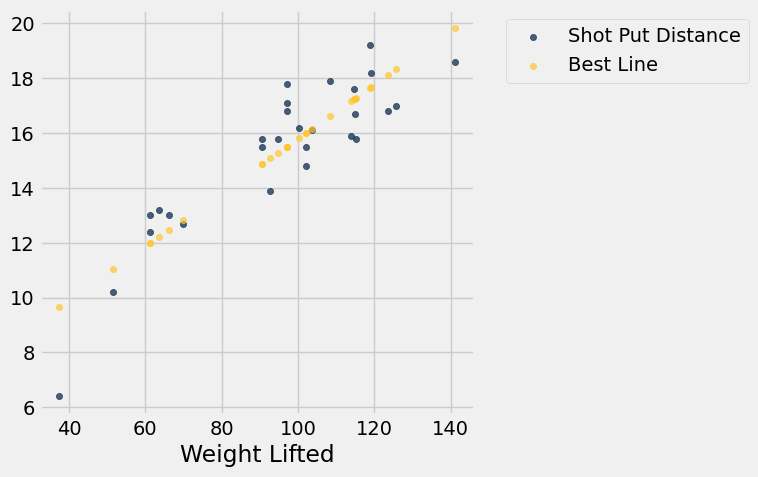

In [36]:
linear_fit = best_line.item(0)*weights + best_line.item(1)

shotput.with_column(
    'Best Line', linear_fit
).scatter(0)

**Quadratic Function**

$$
f(x) ~=~ ax^2 + bx + c
$$
for constants $a$, $b$, and $c$.



In [37]:
def shotput_quadratic_rmse(a, b, c):
    x = shotput.column('Weight Lifted')
    y = shotput.column('Shot Put Distance')
    estimate = a*(x**2) + b*x + c
    return np.mean((y - estimate) ** 2) ** 0.5

In [38]:
best_quad = minimize(shotput_quadratic_rmse)
best_quad

array([ -1.04003731e-03,   2.82706003e-01,  -1.53167618e+00])

In [39]:
quad_fit = best_quad.item(0)*(weights**2) + best_quad.item(1)*weights + best_quad.item(2)

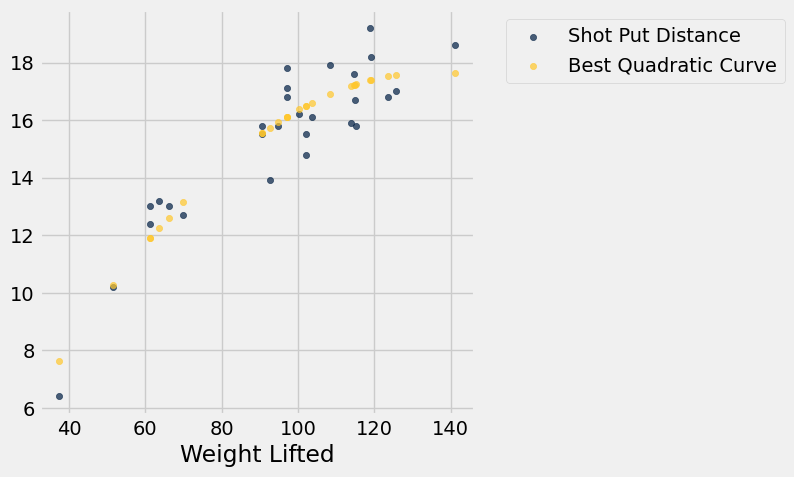

In [40]:
shotput.with_column('Best Quadratic Curve', quad_fit).scatter(0)

## Residuals

In [41]:
demographics = Table.read_table('district_demographics2016.csv')
demographics = demographics.drop(
    'State', 'District', 'Percent voting for Clinton')
demographics.show(5)

Median Income,College%
47083,24
42035,21.8
46544,22.8
41110,17
51690,30.3


In [42]:
def residuals(t, x, y):
    predictions = fitted_values(t, x, y)
    return t.column(y) - predictions

In [43]:
demographics = demographics.with_columns(
    'Fitted Value', fitted_values(demographics, 'College%', 'Median Income'),
    'Residual', residuals(demographics, 'College%', 'Median Income')
)
demographics

Median Income,College%,Fitted Value,Residual
47083,24,51299.4,-4216.42
42035,21.8,48503.9,-6468.87
46544,22.8,49774.6,-3230.58
41110,17,42404.5,-1294.51
51690,30.3,59304.8,-7614.84
61413,36.7,67437.3,-6024.33
34664,19.4,45454.2,-10790.2
76440,29.6,58415.3,18024.7
50537,24.5,51934.8,-1397.77
49072,34,64006.4,-14934.4


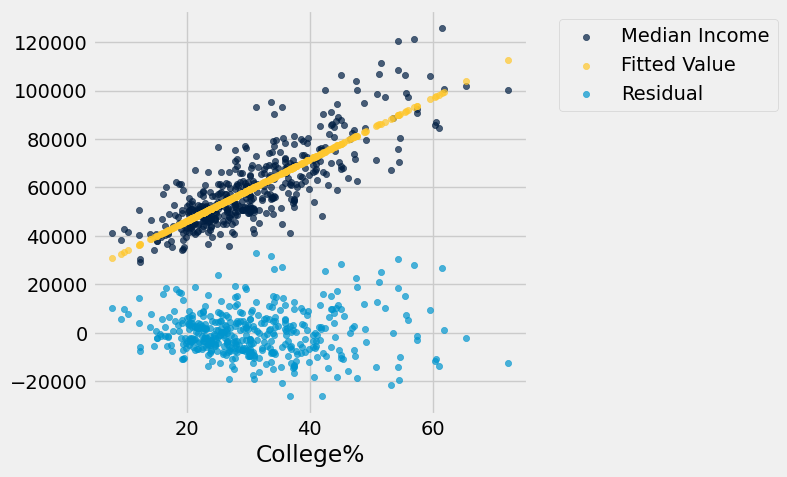

In [44]:
demographics.scatter('College%')

In [45]:
def plot_residuals(t, x, y):
    tbl = t.with_columns(
        'Fitted', fitted_values(t, x, y),
        'Residual', residuals(t, x, y)
    )
    tbl.select(x, y, 'Fitted').scatter(0)
    tbl.scatter(x, 'Residual')

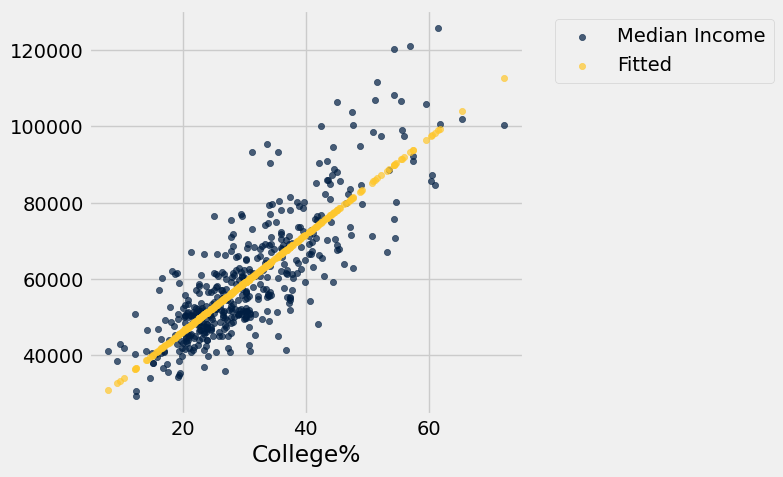

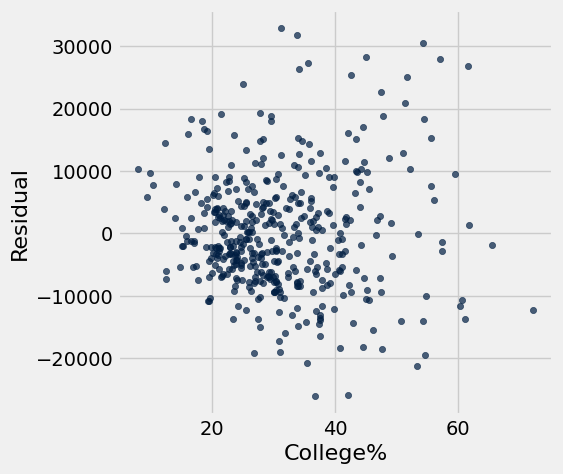

In [46]:
plot_residuals(demographics, 'College%', 'Median Income')

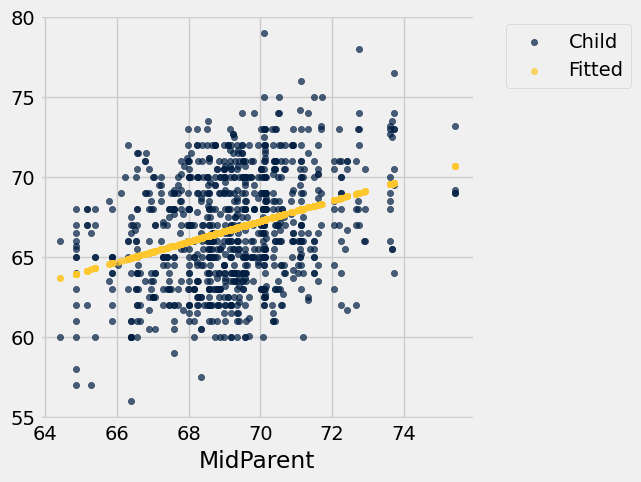

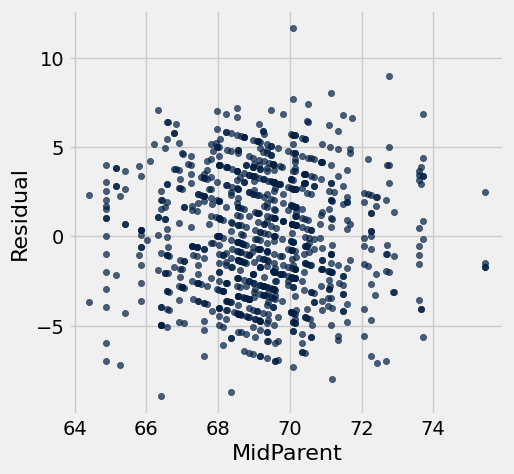

In [47]:
height = Table.read_table('heights.csv')

heights = Table().with_columns(
    'MidParent', height.column('midparentHeight'),
    'Child', height.column('childHeight')
    )
plot_residuals(heights, 'MidParent', 'Child')

## Dugongs ##

In [48]:
dugong = Table.read_table('dugong.csv')
dugong.show(5)

Length,Age
1.8,1
1.85,1.5
1.87,1.5
1.77,1.5
2.02,2.5


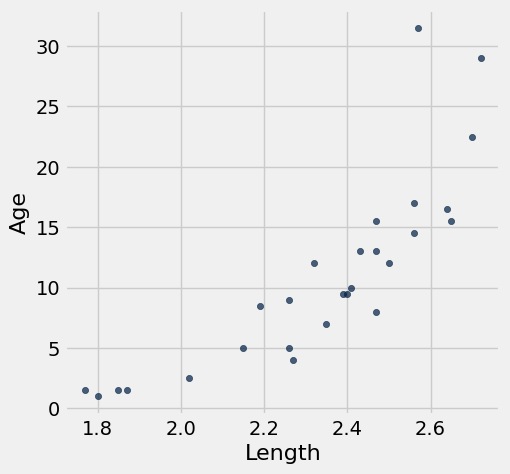

In [49]:
dugong.scatter('Length', 'Age')

In [50]:
correlation(dugong, 'Length', 'Age')

0.82964745549057139

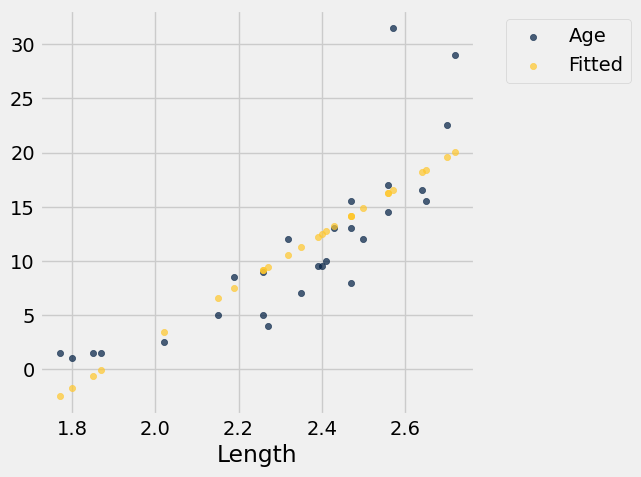

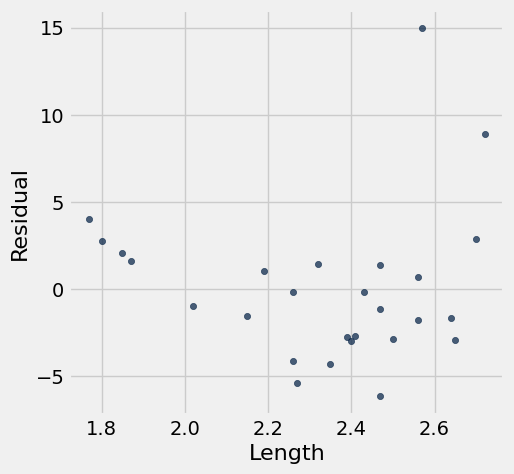

In [51]:
plot_residuals(dugong, 'Length', 'Age')

# US Women

In [52]:
us_women = Table.read_table('us_women.csv')
us_women.show(5)

height,ave weight
58,115
59,117
60,120
61,123
62,126


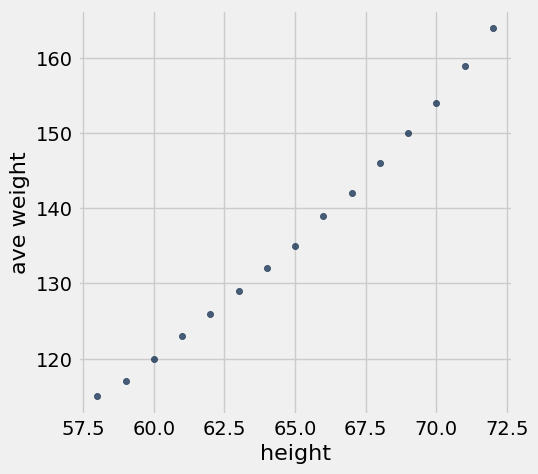

In [53]:
us_women.scatter('height')

In [54]:
correlation(us_women, 'height', 'ave weight')

0.99549476778421608

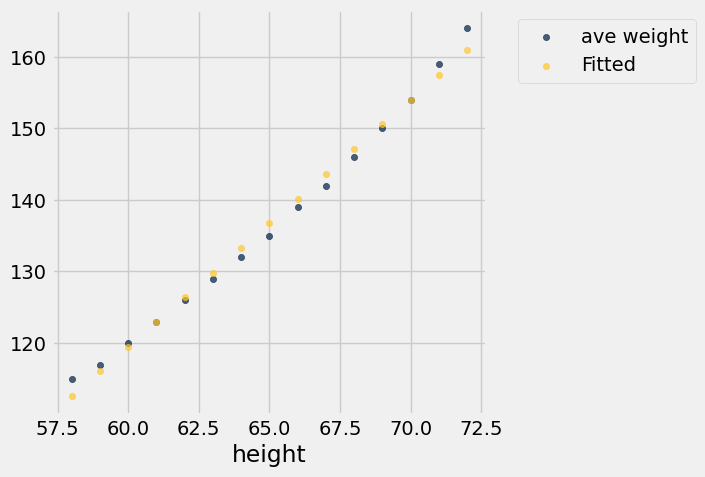

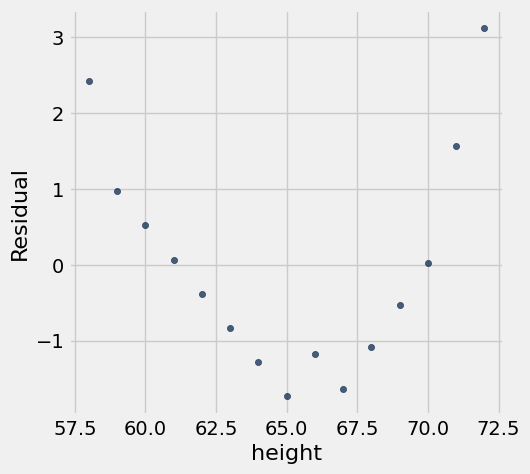

In [55]:
plot_residuals(us_women, 'height', 'ave weight')